# Introduction

The project attempts to create a robust deep network for music genre recognition. The objective is to create a CNN (Convolutional Neural Network) that is capable of continously predicting the probability distribution of a song being of a certain genre. The underlying objective is to understand what features of a song define the genre. In essence, we are converting the features of a sample song to a spectrogram and using supervised learning techniques including the CNN to classify the unknown song's genre using cross-referential spectrogram analysis. Classification accuracy is used as the performance metric to measure the performance of our genre classifier. Our song dataset contained audio files which were converted into mel-spectrograms. Mel-specs allow us to have a better visual representations of how humans perceive certain frequencies. It also decreases the size of the data. They are represented at arrays of floating integers. The reason for using a CRNN was because we needed to memorize what is happening in the song. The architecture of the model allowed us to identify long-term and short-term structures in the songs' frequencies.

# Dataset

For our project, we opted to use the GTZAN dataset which contains 1000 songs across 10 genres each of 30 seconds length. The dataset was created for the IEEE paper "Musical genre classification of audio signals" by George Tzanetakis. The genres are blues, classical, country, disco, hiphop, jazz, metal, pop, reggae and rock. The files were collected in the years 2000 - 2001 from a variety of sources including personal CDs, radio, microphone recordings, in order to represent a variety of recording conditions. The tracks are all 22050 Hz monophonic 16-bit audio files in .au format.

# Mel Spectrogram

To represent the song data as inputs for our neural network, we converted them into mel-spectrograms using the Python library Librosa. This was done also because of CNN's image recognition capabilities. Each mel-spectrogram has 2048 samples per song for the fourier transform on the song, and the number of mels are set to 128 (default). A regular spectogram is squared magnitude of the short term Fourier transform (STFT) of the audio signal. This regular spectogram is squashed using mel scale to convert the audio frequencies into something a human is more able to understand. The Librosa library was used to convert the audio file directly into a mel-spectogram. The most important parameters used in the transformation are — window length which indicates the window of time to perform Fourier Transform on and hop length which is the number of samples between successive frames. The typical window length for this transformation is 2048 which converts to about 10ms, the shortest reasonable period a human ear can distinguish. A hop length of 512 was used. Furthermore, the Mel-spectrograms produced by Librosa are scaled by a log function. This maps the sound data to the normal logarithmic scale used to determine loudness in decibels (dB) as it relates to the human-perceived pitch. As a result of this transformation each audio file gets converted to a mel-spectogram of shape — 640, 128.

# Applications

Genre classification becomes an important task when we look at how much data is being created nowadays. With new songs being released on a daily basis on platforms like Spotify and Pandora, there is a need for accurate meta-data tagging for database management and searching / storing purposes. Being able to instantaneously classify a song in any given streaming platform is an important functionality. This is also the first step for building strong music recommendation systems since the fact that features of songs can be broken down to arrays of numbers.

# Model

We are using a CNN to perform music genre recognition. 

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout, Activation, TimeDistributed, Convolution1D, MaxPooling1D, BatchNormalization
from sklearn.model_selection import train_test_split
import pickle
import os

In [2]:
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal',
          'pop', 'reggae', 'rock']
WINDOW_SIZE = 2048
WINDOW_STRIDE = WINDOW_SIZE // 2
N_MELS = 128
MEL_KWARGS = {
    'n_fft': WINDOW_SIZE,
    'hop_length': WINDOW_STRIDE,
    'n_mels': N_MELS
}

In [3]:
def load_track(filename, enforce_shape=None):
    new_input, sample_rate = librosa.load(filename, mono=True)
    features = librosa.feature.melspectrogram(new_input, **MEL_KWARGS).T

    if enforce_shape is not None:
        if features.shape[0] < enforce_shape[0]:
            delta_shape = (enforce_shape[0] - features.shape[0],
                           enforce_shape[1])
            features = np.append(features, np.zeros(delta_shape), axis=0)
        elif features.shape[0] > enforce_shape[0]:
            features = features[: enforce_shape[0], :]

    features[features == 0] = 1e-6
    return (np.log(features), float(new_input.shape[0]) / sample_rate)

NameError: name 'genre_name' is not defined

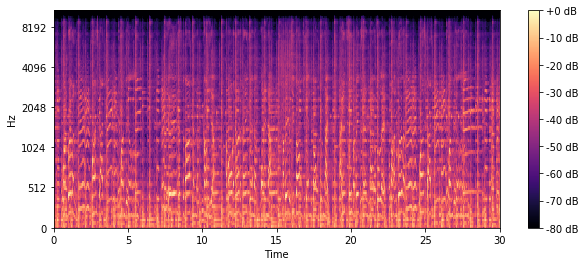

In [9]:
# Making mel-spectrogram (multiple genres)
filename = './data/genres/blues/blues.00000.au'
x, sample_rate = librosa.load(filename, mono=True)
spect = librosa.feature.melspectrogram(x, sr=sample_rate,n_fft=2048, hop_length=512)
spect = librosa.power_to_db(spect, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(spect, sr=sample_rate, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(str(genre_name))
plt.show()

In [ ]:
SEED = 42
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 256
BATCH_SIZE = 32
EPOCH_COUNT = 100

In [ ]:
def train_model(data):
    x = data['x']
    y = data['y']
    (x_train, x_val, y_train, y_val) = train_test_split(x, y, test_size=0.1, stratify=y,
                                                        random_state=SEED)

    print('Building model...')

    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    layer = model_input
    for i in range(N_LAYERS):
        # second convolutional layer names are used by extract_filters.py
        layer = Convolution1D(
            filters=CONV_FILTER_COUNT,
            kernel_size=FILTER_LENGTH,
            name='convolution_' + str(i + 1)
        )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.5)(layer)

    layer = TimeDistributed(Dense(len(GENRES)))(layer)
    time_distributed_merge_layer = Lambda(
        function=lambda x: K.mean(x, axis=1),
        output_shape=lambda shape: (shape[0],) + shape[2:],
        name='output_merged'
    )
    layer = time_distributed_merge_layer(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    opt = Adam(lr=0.001)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

    print(model.summary())

    print('Training...')
    print('Verbosity set to zero...')
    # NOTE: Verbosity == 0 so no messages visible during training
    history = model.fit(
        x_train, y_train, batch_size=BATCH_SIZE, nb_epoch=EPOCH_COUNT,
        validation_split=0.11, verbose=0, callbacks=[
            ModelCheckpoint(
                model_path, save_best_only=True, monitor='val_accuracy', verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
        ]
    )

    print("Final model accuracy on Test data: ", model.evaluate(x_val, y_val))

    return model, history

In [ ]:
data_path = './data/data.pkl'
model_path = './models/model.h5'

with open(data_path, 'rb') as f:
    data = pickle.load(f)

train_model(data, model_path)

model, model_history = train_model(data, model_path)

In [ ]:
def show_summary_stats(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Test'], loc='upper left')
    plt.show()

In [ ]:
def confusion_mat(x_val, y_val):
    conf_mat = confusion_matrix(x_val, y_val)
    fig, ax = plt.subplots(1)
    ax = sns.heatmap(conf_mat.T, annot=True, xticklabels=GENRES, yticklabels=GENRES)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('Confusion Matrix for the Test Set')
    plt.show()

In [ ]:
# Model Analysis

show_summary_stats(model_history)

y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)
y_target = np.argmax(y_val, axis=1)

confusion_mat(y_pred, y_target)